In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
import copy
from sklearn.model_selection import train_test_split


# NEW! for importing data
import torchvision

import matplotlib.pyplot as plt

In [2]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Import and inspect the data

In [3]:
# download the dataset
cdata = torchvision.datasets.EMNIST(root='emnist',split='letters',download=True)

# more info: https://www.nist.gov/itl/products-and-services/emnist-dataset

In [4]:
# inspect the data

# the categories (but how many letters??)
print(cdata.classes)
print(str(len(cdata.classes)) + ' classes')

print('\nData size:')
print(cdata.data.shape)

# transform to 4D tensor for conv layers (and transform from int8 to float)
images = cdata.data.view([124800,1,28,28]).float()

# normalize the images
images /= torch.max(images)

print('\nTensor data:')
print(images.shape)

['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
27 classes

Data size:
torch.Size([124800, 28, 28])

Tensor data:
torch.Size([124800, 1, 28, 28])


In [5]:
# eliminate missing category and subtract 1 from the original

# remove the first class category
letterCategories = cdata.classes[1:]

# relabel labels to start at 0
labels = copy.deepcopy(cdata.targets)-1

# Create train/test groups using DataLoader

In [6]:
# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(images, labels, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

# Create the DL model

In [7]:
# create a class for the model
def makeTheNet(numchans=(6,6)):

    class emnistnet(nn.Module):
        def __init__(self,numchans):
            super().__init__()

            ### -------------- feature map layers -------------- ###
            # first convolution layer
            self.conv1  = nn.Conv2d(1,numchans[0],3,padding=1)
            self.bnorm1 = nn.BatchNorm2d(numchans[0])

            # second convolution layer
            self.conv2  = nn.Conv2d(numchans[0],numchans[1],3,padding=1)
            self.bnorm2 = nn.BatchNorm2d(numchans[1])


            ### -------------- linear decision layers -------------- ###
            self.fc1 = nn.Linear(7*7*numchans[1],50)
            self.fc2 = nn.Linear(50,26)

        def forward(self,x):
      
            # first block: convolution -> maxpool -> batchnorm -> relu
            x = F.max_pool2d(self.conv1(x),2)
            x = F.leaky_relu(self.bnorm1(x))

            # second block: convolution -> maxpool -> batchnorm -> relu
            x = F.max_pool2d(self.conv2(x),2)
            x = F.leaky_relu(self.bnorm2(x))

            # reshape for linear layer
            nUnits = x.shape.numel()/x.shape[0]
            x = x.view(-1,int(nUnits))

            # linear layers
            x = F.leaky_relu(self.fc1(x))
            x = self.fc2(x)

            return x

    # create the model instance
    net = emnistnet(numchans)

    # loss function
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.Adam(net.parameters(),lr=.001)

    return net,lossfun,optimizer

In [8]:
# test the model with one batch
net,lossfun,optimizer = makeTheNet((6,12))

X,y = iter(train_loader).next()
yHat = net(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,torch.squeeze(y))
print(' ')
print('Loss:')
print(loss)


Output size:
torch.Size([32, 26])
 
Loss:
tensor(3.3751, grad_fn=<NllLossBackward0>)


# Create a function that trains the model

In [9]:
# a function that trains the model

def function2trainTheModel(numchans):

    # number of epochs
    numepochs = 5

    # create a new model
    net,lossfun,optimizer = makeTheNet(numchans)

    # send the model to the GPU
    net.to(device)

    # initialize losses
    trainLoss = torch.zeros(numepochs)
    testLoss  = torch.zeros(numepochs)
    trainErr  = torch.zeros(numepochs)
    testErr   = torch.zeros(numepochs)


    # loop over epochs
    for epochi in range(numepochs):

        # loop over training data batches
        net.train()
        batchLoss = []
        batchErr  = []
        for X,y in train_loader:
      
            # push data to GPU
            X = X.to(device)
            y = y.to(device)

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat,y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss and error rate from this batch
            batchLoss.append(loss.item())
            batchErr.append( torch.mean((torch.argmax(yHat,axis=1) != y).float()).item() )
        # end of batch loop...

        # and get average losses across the batches
        trainLoss[epochi] = np.mean(batchLoss)
        trainErr[epochi]  = 100*np.mean(batchErr)

        # test performance
        net.eval()
        X,y = next(iter(test_loader)) # extract X,y from test dataloader

        # push data to GPU
        X = X.to(device)
        y = y.to(device)

        with torch.no_grad(): # deactivates autograd
            yHat = net(X)
            loss = lossfun(yHat,y)
      
        # extract loss and error rates for test batch
        testLoss[epochi] = loss.item()
        testErr[epochi]  = 100*torch.mean((torch.argmax(yHat,axis=1) != y).float()).item()

    # end epochs

    # function output
    return trainLoss,testLoss,trainErr,testErr,net

# Run the model and show the results!

In [10]:
trainLoss,testLoss,trainErr,testErr,net = function2trainTheModel((3,7))

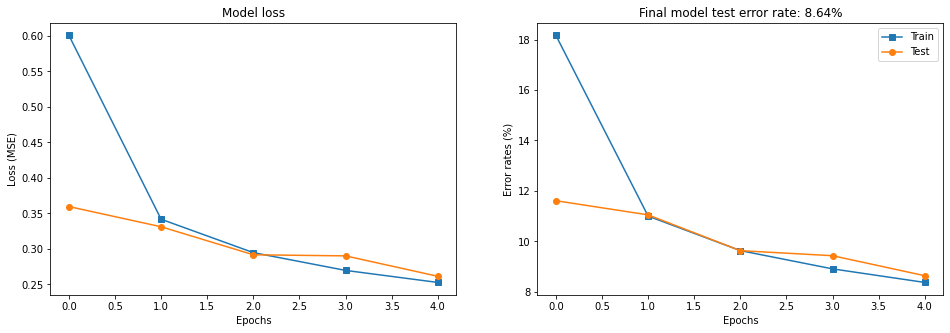

In [11]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainErr,'s-',label='Train')
ax[1].plot(testErr,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error rates (%)')
ax[1].set_title(f'Final model test error rate: {testErr[-1]:.2f}%')
ax[1].legend()

plt.show()

# Now for the experiment

In [12]:
# this experiment takes ~8 mins on a GPU
convChans = [2,5,8]

# initialize results matrix
results    = np.zeros((len(convChans),len(convChans),2))
convParams = np.zeros((len(convChans),len(convChans)))

for i,Nchani in enumerate(convChans):
    for j,Nchanj in enumerate(convChans):
    
        # run the model
        trainLoss,testLoss,trainErr,testErr,net = function2trainTheModel((Nchani,Nchanj))

        # get results
        results[i,j,:]  = trainErr[-1],testErr[-1]
        convParams[i,j] = Nchani+Nchanj # total number of convolution layer channels

        print(i,j)

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2


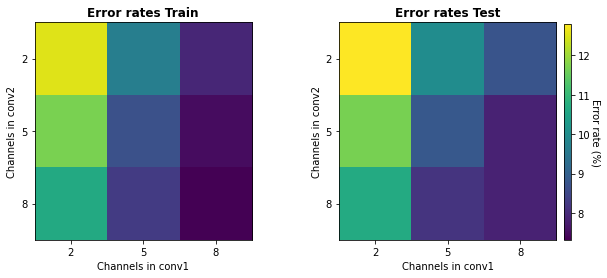

In [13]:
# Show the results matrix

fig,ax = plt.subplots(1,2,figsize=(10,4))

for i in range(2):
    h = ax[i].imshow(results[:,:,i],vmin=np.min(results),vmax=np.max(results))
    ax[i].set_xlabel('Channels in conv1')
    ax[i].set_ylabel('Channels in conv2')
    ax[i].set_xticks(range(j+1)) # j defined in previous cell
    ax[i].set_yticks(range(j+1))
    ax[i].set_xticklabels(convChans)
    ax[i].set_yticklabels(convChans)
    title = 'Train' if i==0 else 'Test'
    ax[i].set_title('Error rates %s'%title,fontweight='bold')


# add a colorbar right of the plot (use common colorscaling for both plots)
axpos = ax[1].get_position()
cax = fig.add_axes([axpos.x1+.01,axpos.y0,.01,.75])
hh = fig.colorbar(h,cax=cax)
hh.set_label('Error rate (%)',rotation=270,labelpad=10)

plt.show()

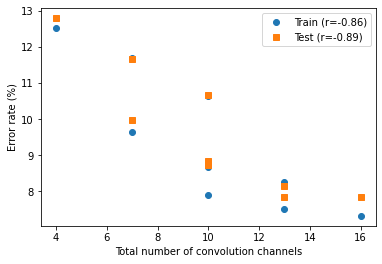

In [14]:
# error rate as a function of the total number of conv channels

corrTrain = np.corrcoef(convParams.flatten(),results[:,:,0].flatten())
corrTest  = np.corrcoef(convParams.flatten(),results[:,:,1].flatten())

# plots
plt.plot(convParams.flatten(),results[:,:,0].flatten(),'o',
         label=f'Train (r={corrTrain[0,1]:.2f})')
plt.plot(convParams.flatten(),results[:,:,1].flatten(),'s',
         label=f'Test (r={corrTest[0,1]:.2f})')

# other stuff etc
plt.legend()
plt.xlabel('Total number of convolution channels')
plt.ylabel('Error rate (%)')
plt.show()

# Additional explorations

In [15]:
# 1) The correlation between error rate and convolution channels looks pretty compelling. How far do you dare go?!?! Try
#    adding more channels. Does the error rate simply keep going down until it reaches zero? Or do you find a point of
#    "diminishing returns", meaning that adding more channels no longer improves performance.
# 
# 2) It seems intuitive that models with more layers take longer to train. But if there's one thing you've learned about
#    deep learning, it's that intuition doesn't always get us very far. Thus: modify the code to track the training time
#    for each model. Store the results in a separate matrix, and make an image of those results. Do they look like what
#    you had expected?
# 
# 3) Are net.train() and net.eval() necessary here? Why or why not?